In [52]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
df= pd.read_csv("mainDataset-all-cool.csv", skipinitialspace=True, sep=";")


In [54]:
target_names = list(df['CurElementMark'].unique())

In [55]:
target_names

['b1', 'c1', 'c2', 'd2', 'b2', 'h1', 'b3', 'f1', 'g1', 'j0', 'e1', 'i1', 'f3']

### Список классов текстовых элементов docx-документа
Заголовок
- b1 - Заголовок первого уровня
- b2 - Заголовок второго уровня
- b3 - Заголовок третьего уровня

Абзац
- c1 - обычный абзац
- c2 - абзац перед списком
- c3 - абзац перед формулой

Перечисления (список)
- d1 - первый элемент простого перечисления - заменен в датасете на d2
- d2 - элемент простого перечисления, находящийся между первым и последним элементами списка;
- d3 - последний элемент простого перечисления

Изображение 
- g1 - изображение

Подпись изображения
- h1 - подпись рисунка, который как отдельный параграф 

Подпись таблицы
- f1 - подпись и нумерация таблиц в тексте








## Количество элементов по признакам

<Axes: xlabel='count', ylabel='CurElementMark'>

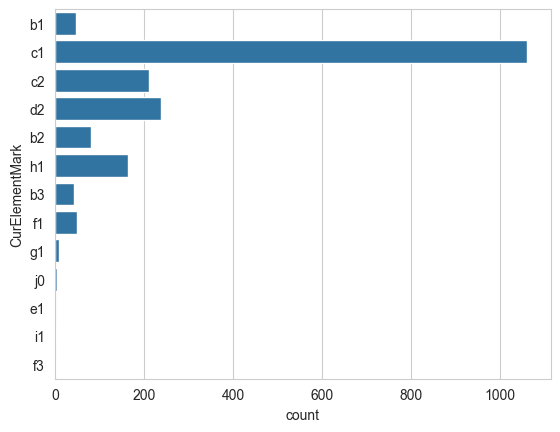

In [56]:
sns.countplot(df['CurElementMark'])

## Пустые значения

<Axes: >

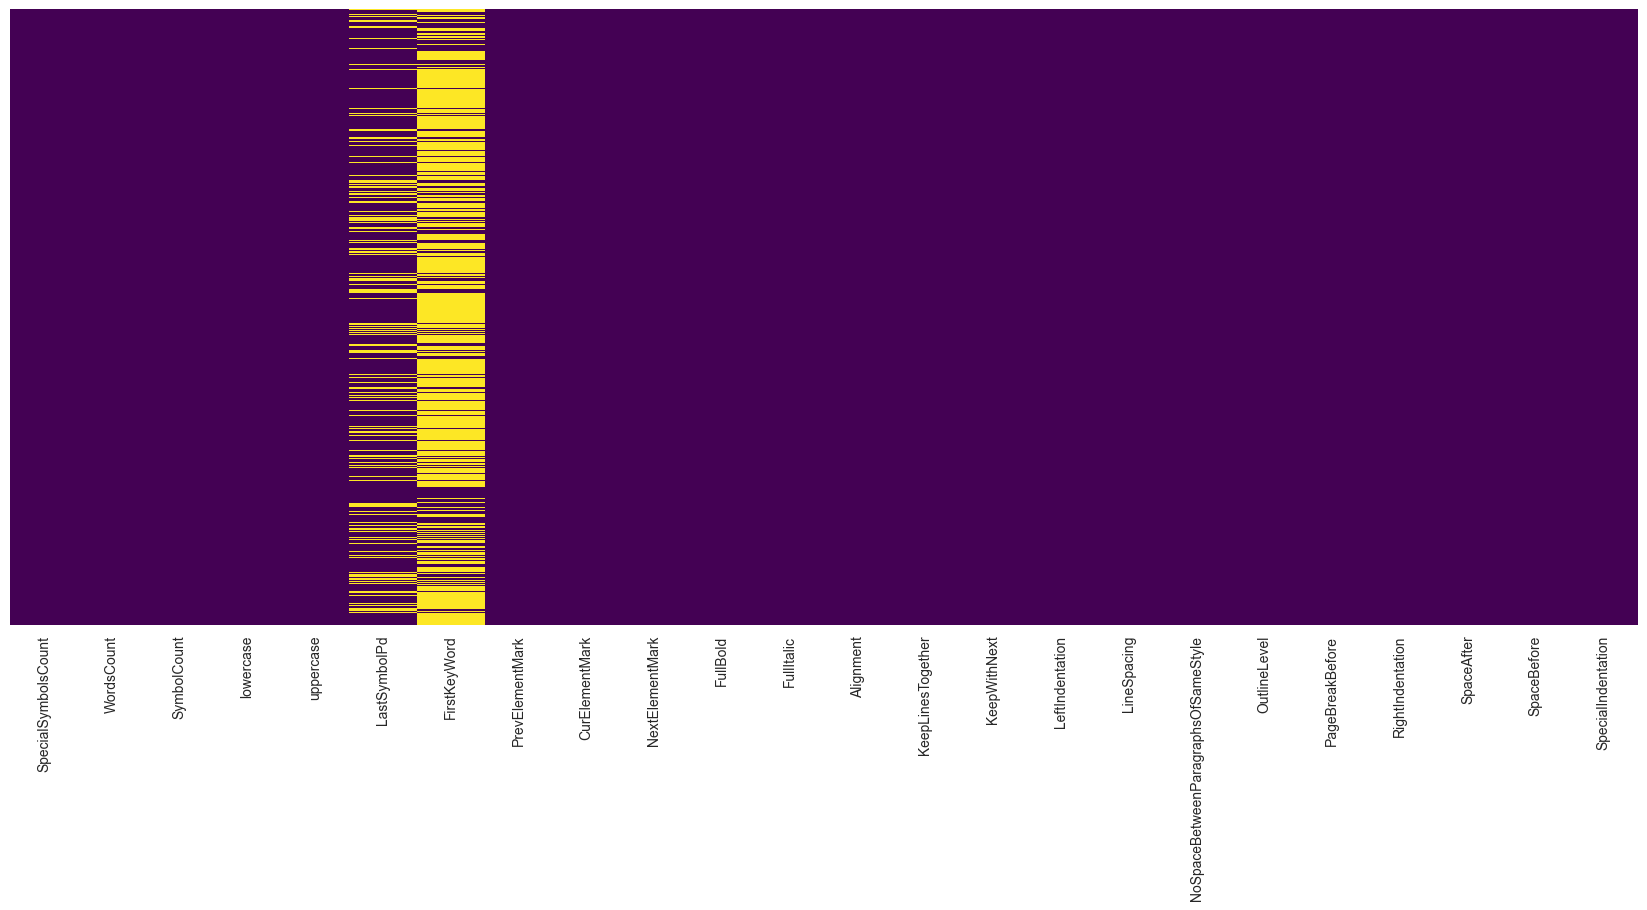

In [57]:
plt.figure(figsize=(21,8))
sns.set_style('whitegrid')
sns.heatmap(df.isnull(), cmap = 'viridis', yticklabels = False, cbar = False)

In [58]:
feature_with_na_values = [feature for feature in df.columns if df[feature].isnull().sum()>1]
for feature in feature_with_na_values:
    print(feature, np.round(df[feature].isnull().mean(),4), '% пропущенных значений')

LastSymbolPd 0.223 % пропущенных значений
FirstKeyWord 0.7092 % пропущенных значений


## Общая информация о датасете

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1919 entries, 0 to 1918
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   SpecialSymbolsCount                  1919 non-null   int64 
 1   WordsCount                           1919 non-null   int64 
 2   SymbolCount                          1919 non-null   int64 
 3   lowercase                            1919 non-null   bool  
 4   uppercase                            1919 non-null   bool  
 5   LastSymbolPd                         1491 non-null   object
 6   FirstKeyWord                         558 non-null    object
 7   PrevElementMark                      1919 non-null   object
 8   CurElementMark                       1919 non-null   object
 9   NextElementMark                      1919 non-null   object
 10  FullBold                             1919 non-null   bool  
 11  FullItalic                           1919 n

Количество категориальных и числовых признаков

In [60]:
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
len(categorical_features)

12

In [61]:
numerical_features = [feature for feature in df.columns if feature not in categorical_features]
len(numerical_features)

12

In [62]:
df.describe()

,SpecialSymbolsCount,WordsCount,SymbolCount,SpaceBefore
count,1919.000000,1919.000000,1919.000000,1919.000000
mean,5.454924,27.286087,218.247525,0.879625
std,6.075895,30.554930,241.368122,3.205443
min,0.000000,1.000000,5.000000,0.000000
25%,2.000000,7.000000,55.000000,0.000000
50%,3.000000,16.000000,136.000000,0.000000
75%,7.000000,37.000000,298.500000,0.000000
max,50.000000,266.000000,1872.000000,24.000000


## Предобработка и словари

Перечень полей типа 'object'

In [63]:
objectType = list(df.select_dtypes(['object']).columns)
objectType

['LastSymbolPd',
 'FirstKeyWord',
 'PrevElementMark',
 'CurElementMark',
 'NextElementMark',
 'Alignment',
 'LeftIndentation',
 'LineSpacing',
 'OutlineLevel',
 'RightIndentation',
 'SpaceAfter',
 'SpecialIndentation']

Перечень полей типа 'bool'

In [64]:
boolType = list(df.select_dtypes(['bool']).columns)
boolType

['lowercase',
 'uppercase',
 'FullBold',
 'FullItalic',
 'KeepLinesTogether',
 'KeepWithNext',
 'NoSpaceBetweenParagraphsOfSameStyle',
 'PageBreakBefore']

### Словари для true и false

Препроцессинг данных. Все объеденено в одну фцнкцию.

Фукция возвразает набор словарей.

Для обращения к словарю, можно обратиться к переменной mappings["Alignment"].

В дальнейшем, для всех тестовых данных должны использоваться именно эти словари.

+ Для булевых полей ставим 0 и 1
+ LastSymbolPd по словарю {np.nan: 4, "." :0, ":" : 1 , ";" : 2, "," : 4}

In [65]:
mappings = {}
def preprocess(df,boolType,objectType):
    le = LabelEncoder()
    for i in boolType:
        df[i] = df[i].astype(int)
    for i in objectType:
        df[i] = df[i].fillna('0')
        le.fit(df[i])
        df[i] = le.transform(df[i])
        mappings[i] = dict(zip(le.classes_, le.transform(le.classes_)))
    return mappings

In [66]:
mappings

{}

In [67]:
df["FirstKeyWord"].unique()

array([nan, 'listLevel1', 'TitleLevel1', 'TitleLevel2', 'Рисунок',
       'Выводы', 'Таблица', 'SHAPE', 'ВЫВОДЫ', '2.3.', 'PRESERVED',
       'TitleLevel3'], dtype=object)

In [68]:
mappings = preprocess(df,boolType,objectType);

**Обращение к элементам словарей**

=======================================================================================================================

In [69]:
mapAlignment = mappings["Alignment"]
mapAlignment

{'Center': 0, 'Justify': 1, 'Left': 2, 'Right': 3}

In [70]:
df["Alignment"]

0       0
1       1
2       1
3       1
4       1
       ..
1914    1
1915    0
1916    1
1917    1
1918    1
Name: Alignment, Length: 1919, dtype: int32

In [71]:
df["Alignment"].unique()

array([0, 1, 2, 3])

In [72]:
mapAlignment = {v:k for k, v in mapAlignment.items()} # меняем местами ключ-значение
mapAlignment
df["Alignment"].map(mapAlignment)

0        Center
1       Justify
2       Justify
3       Justify
4       Justify
         ...   
1914    Justify
1915     Center
1916    Justify
1917    Justify
1918    Justify
Name: Alignment, Length: 1919, dtype: object

=======================================================================================================================

In [73]:
df

,SpecialSymbolsCount,WordsCount,SymbolCount,lowercase,uppercase,LastSymbolPd,FirstKeyWord,PrevElementMark,CurElementMark,NextElementMark,...,KeepWithNext,LeftIndentation,LineSpacing,NoSpaceBetweenParagraphsOfSameStyle,OutlineLevel,PageBreakBefore,RightIndentation,SpaceAfter,SpaceBefore,SpecialIndentation
0,0,1,8,0,0,2,0,3,0,3,...,1,0,5,0,1,0,2,0,0,5
1,9,48,386,0,0,1,0,0,3,3,...,0,0,5,0,0,0,2,0,0,5
2,12,67,535,0,0,1,0,3,3,3,...,0,0,5,0,0,0,2,0,0,5
3,11,54,405,0,0,1,0,3,3,4,...,0,0,5,0,0,0,2,0,0,5
4,1,5,37,0,0,3,0,3,4,5,...,0,0,5,0,0,0,2,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914,5,21,184,0,0,1,0,6,3,0,...,0,0,5,0,0,0,2,0,12,5
1915,0,1,10,0,1,2,0,3,0,3,...,1,0,5,0,1,0,2,3,0,7
1916,9,57,486,0,0,1,0,0,3,3,...,0,0,5,0,0,0,2,0,0,5
1917,4,49,365,0,0,1,0,3,3,3,...,0,0,5,0,0,0,2,0,0,5


# Обучение модели CatBoost

In [74]:
y = df["CurElementMark"]
X = df.drop("CurElementMark", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [75]:
model = CatBoostClassifier(iterations=3000 , task_type="CPU",depth= 4, l2_leaf_reg=3, learning_rate=0.1)

In [76]:
cat = model.fit(X_train, y_train)

0:	learn: 1.8393550	total: 5.23ms	remaining: 15.7s
1:	learn: 1.5346232	total: 13.4ms	remaining: 20.1s
2:	learn: 1.3370144	total: 18.8ms	remaining: 18.8s
3:	learn: 1.1830625	total: 22.3ms	remaining: 16.7s
4:	learn: 1.0583066	total: 27.6ms	remaining: 16.5s
5:	learn: 0.9541377	total: 31ms	remaining: 15.5s
6:	learn: 0.8664312	total: 34.5ms	remaining: 14.7s
7:	learn: 0.7929992	total: 38ms	remaining: 14.2s
8:	learn: 0.7299772	total: 41.5ms	remaining: 13.8s
9:	learn: 0.6772671	total: 45.1ms	remaining: 13.5s
10:	learn: 0.6336240	total: 48.5ms	remaining: 13.2s
11:	learn: 0.5929504	total: 52.3ms	remaining: 13s
12:	learn: 0.5526965	total: 56.2ms	remaining: 12.9s
13:	learn: 0.5196676	total: 59.8ms	remaining: 12.8s
14:	learn: 0.4853852	total: 63.3ms	remaining: 12.6s
15:	learn: 0.4555809	total: 66.7ms	remaining: 12.4s
16:	learn: 0.4319704	total: 70.6ms	remaining: 12.4s
17:	learn: 0.4079042	total: 73.9ms	remaining: 12.2s
18:	learn: 0.3876312	total: 77.3ms	remaining: 12.1s
19:	learn: 0.3678785	total: 

174:	learn: 0.0662029	total: 615ms	remaining: 9.93s
175:	learn: 0.0657404	total: 619ms	remaining: 9.94s
176:	learn: 0.0655954	total: 623ms	remaining: 9.94s
177:	learn: 0.0651655	total: 628ms	remaining: 9.96s
178:	learn: 0.0648018	total: 633ms	remaining: 9.97s
179:	learn: 0.0647326	total: 637ms	remaining: 9.98s
180:	learn: 0.0644322	total: 640ms	remaining: 9.97s
181:	learn: 0.0641039	total: 645ms	remaining: 9.98s
182:	learn: 0.0639736	total: 648ms	remaining: 9.97s
183:	learn: 0.0636917	total: 651ms	remaining: 9.96s
184:	learn: 0.0633351	total: 654ms	remaining: 9.95s
185:	learn: 0.0632844	total: 658ms	remaining: 9.95s
186:	learn: 0.0630733	total: 661ms	remaining: 9.94s
187:	learn: 0.0629549	total: 664ms	remaining: 9.93s
188:	learn: 0.0628815	total: 667ms	remaining: 9.91s
189:	learn: 0.0622310	total: 670ms	remaining: 9.91s
190:	learn: 0.0618836	total: 673ms	remaining: 9.9s
191:	learn: 0.0614588	total: 676ms	remaining: 9.89s
192:	learn: 0.0609275	total: 680ms	remaining: 9.89s
193:	learn: 0

354:	learn: 0.0337741	total: 1.21s	remaining: 9.04s
355:	learn: 0.0336855	total: 1.22s	remaining: 9.04s
356:	learn: 0.0334032	total: 1.22s	remaining: 9.04s
357:	learn: 0.0332608	total: 1.23s	remaining: 9.07s
358:	learn: 0.0331478	total: 1.23s	remaining: 9.07s
359:	learn: 0.0328980	total: 1.24s	remaining: 9.07s
360:	learn: 0.0328003	total: 1.24s	remaining: 9.06s
361:	learn: 0.0326985	total: 1.24s	remaining: 9.07s
362:	learn: 0.0326274	total: 1.25s	remaining: 9.06s
363:	learn: 0.0325155	total: 1.25s	remaining: 9.06s
364:	learn: 0.0324806	total: 1.25s	remaining: 9.05s
365:	learn: 0.0324029	total: 1.26s	remaining: 9.04s
366:	learn: 0.0323528	total: 1.26s	remaining: 9.06s
367:	learn: 0.0321896	total: 1.27s	remaining: 9.06s
368:	learn: 0.0320289	total: 1.27s	remaining: 9.05s
369:	learn: 0.0319853	total: 1.27s	remaining: 9.04s
370:	learn: 0.0318516	total: 1.28s	remaining: 9.05s
371:	learn: 0.0318155	total: 1.28s	remaining: 9.05s
372:	learn: 0.0317088	total: 1.28s	remaining: 9.04s
373:	learn: 

526:	learn: 0.0210687	total: 1.83s	remaining: 8.62s
527:	learn: 0.0210338	total: 1.84s	remaining: 8.62s
528:	learn: 0.0209989	total: 1.86s	remaining: 8.69s
529:	learn: 0.0209247	total: 1.87s	remaining: 8.71s
530:	learn: 0.0208673	total: 1.87s	remaining: 8.7s
531:	learn: 0.0207696	total: 1.88s	remaining: 8.71s
532:	learn: 0.0207456	total: 1.88s	remaining: 8.7s
533:	learn: 0.0207209	total: 1.88s	remaining: 8.7s
534:	learn: 0.0206551	total: 1.89s	remaining: 8.69s
535:	learn: 0.0206050	total: 1.89s	remaining: 8.69s
536:	learn: 0.0205479	total: 1.89s	remaining: 8.68s
537:	learn: 0.0204855	total: 1.9s	remaining: 8.68s
538:	learn: 0.0204536	total: 1.9s	remaining: 8.67s
539:	learn: 0.0204081	total: 1.9s	remaining: 8.67s
540:	learn: 0.0203018	total: 1.91s	remaining: 8.66s
541:	learn: 0.0202427	total: 1.91s	remaining: 8.66s
542:	learn: 0.0202100	total: 1.91s	remaining: 8.65s
543:	learn: 0.0201768	total: 1.92s	remaining: 8.65s
544:	learn: 0.0201410	total: 1.92s	remaining: 8.64s
545:	learn: 0.0200

700:	learn: 0.0149654	total: 2.45s	remaining: 8.03s
701:	learn: 0.0149518	total: 2.45s	remaining: 8.02s
702:	learn: 0.0149272	total: 2.45s	remaining: 8.02s
703:	learn: 0.0149041	total: 2.46s	remaining: 8.02s
704:	learn: 0.0148688	total: 2.46s	remaining: 8.02s
705:	learn: 0.0148519	total: 2.47s	remaining: 8.02s
706:	learn: 0.0148036	total: 2.47s	remaining: 8.01s
707:	learn: 0.0147825	total: 2.47s	remaining: 8.01s
708:	learn: 0.0147558	total: 2.48s	remaining: 8s
709:	learn: 0.0147018	total: 2.48s	remaining: 8s
710:	learn: 0.0146705	total: 2.48s	remaining: 7.99s
711:	learn: 0.0146460	total: 2.49s	remaining: 7.99s
712:	learn: 0.0146253	total: 2.49s	remaining: 7.99s
713:	learn: 0.0146122	total: 2.49s	remaining: 7.98s
714:	learn: 0.0145873	total: 2.5s	remaining: 7.97s
715:	learn: 0.0145442	total: 2.5s	remaining: 7.97s
716:	learn: 0.0144745	total: 2.5s	remaining: 7.97s
717:	learn: 0.0144563	total: 2.5s	remaining: 7.96s
718:	learn: 0.0144221	total: 2.51s	remaining: 7.96s
719:	learn: 0.0144069	

879:	learn: 0.0112526	total: 3.04s	remaining: 7.32s
880:	learn: 0.0112316	total: 3.04s	remaining: 7.32s
881:	learn: 0.0112191	total: 3.04s	remaining: 7.31s
882:	learn: 0.0112045	total: 3.05s	remaining: 7.32s
883:	learn: 0.0111937	total: 3.06s	remaining: 7.31s
884:	learn: 0.0111890	total: 3.06s	remaining: 7.31s
885:	learn: 0.0111643	total: 3.06s	remaining: 7.3s
886:	learn: 0.0111508	total: 3.06s	remaining: 7.3s
887:	learn: 0.0111418	total: 3.07s	remaining: 7.3s
888:	learn: 0.0111368	total: 3.07s	remaining: 7.29s
889:	learn: 0.0111197	total: 3.07s	remaining: 7.29s
890:	learn: 0.0111085	total: 3.08s	remaining: 7.29s
891:	learn: 0.0110874	total: 3.08s	remaining: 7.29s
892:	learn: 0.0110764	total: 3.09s	remaining: 7.29s
893:	learn: 0.0110595	total: 3.09s	remaining: 7.29s
894:	learn: 0.0110478	total: 3.1s	remaining: 7.28s
895:	learn: 0.0110327	total: 3.1s	remaining: 7.28s
896:	learn: 0.0110209	total: 3.1s	remaining: 7.28s
897:	learn: 0.0110013	total: 3.11s	remaining: 7.28s
898:	learn: 0.0109

1047:	learn: 0.0090270	total: 3.62s	remaining: 6.74s
1048:	learn: 0.0090148	total: 3.62s	remaining: 6.74s
1049:	learn: 0.0090049	total: 3.63s	remaining: 6.73s
1050:	learn: 0.0089905	total: 3.63s	remaining: 6.73s
1051:	learn: 0.0089823	total: 3.63s	remaining: 6.73s
1052:	learn: 0.0089774	total: 3.64s	remaining: 6.73s
1053:	learn: 0.0089723	total: 3.64s	remaining: 6.72s
1054:	learn: 0.0089634	total: 3.64s	remaining: 6.72s
1055:	learn: 0.0089516	total: 3.65s	remaining: 6.71s
1056:	learn: 0.0089454	total: 3.65s	remaining: 6.71s
1057:	learn: 0.0089339	total: 3.65s	remaining: 6.71s
1058:	learn: 0.0089236	total: 3.66s	remaining: 6.7s
1059:	learn: 0.0089101	total: 3.66s	remaining: 6.7s
1060:	learn: 0.0089041	total: 3.66s	remaining: 6.7s
1061:	learn: 0.0088941	total: 3.67s	remaining: 6.69s
1062:	learn: 0.0088880	total: 3.67s	remaining: 6.69s
1063:	learn: 0.0088790	total: 3.67s	remaining: 6.68s
1064:	learn: 0.0088726	total: 3.68s	remaining: 6.68s
1065:	learn: 0.0088636	total: 3.68s	remaining: 6.

1220:	learn: 0.0074561	total: 4.22s	remaining: 6.15s
1221:	learn: 0.0074426	total: 4.22s	remaining: 6.14s
1222:	learn: 0.0074379	total: 4.23s	remaining: 6.14s
1223:	learn: 0.0074323	total: 4.23s	remaining: 6.14s
1224:	learn: 0.0074190	total: 4.23s	remaining: 6.13s
1225:	learn: 0.0074160	total: 4.24s	remaining: 6.13s
1226:	learn: 0.0074087	total: 4.24s	remaining: 6.13s
1227:	learn: 0.0073972	total: 4.25s	remaining: 6.13s
1228:	learn: 0.0073879	total: 4.25s	remaining: 6.12s
1229:	learn: 0.0073778	total: 4.25s	remaining: 6.12s
1230:	learn: 0.0073708	total: 4.26s	remaining: 6.12s
1231:	learn: 0.0073577	total: 4.26s	remaining: 6.11s
1232:	learn: 0.0073542	total: 4.26s	remaining: 6.11s
1233:	learn: 0.0073476	total: 4.27s	remaining: 6.11s
1234:	learn: 0.0073392	total: 4.27s	remaining: 6.1s
1235:	learn: 0.0073289	total: 4.27s	remaining: 6.1s
1236:	learn: 0.0073207	total: 4.28s	remaining: 6.09s
1237:	learn: 0.0073165	total: 4.28s	remaining: 6.09s
1238:	learn: 0.0073072	total: 4.28s	remaining: 6

1397:	learn: 0.0062961	total: 4.82s	remaining: 5.52s
1398:	learn: 0.0062891	total: 4.82s	remaining: 5.52s
1399:	learn: 0.0062789	total: 4.83s	remaining: 5.51s
1400:	learn: 0.0062757	total: 4.83s	remaining: 5.51s
1401:	learn: 0.0062709	total: 4.83s	remaining: 5.51s
1402:	learn: 0.0062671	total: 4.84s	remaining: 5.5s
1403:	learn: 0.0062635	total: 4.84s	remaining: 5.5s
1404:	learn: 0.0062572	total: 4.84s	remaining: 5.5s
1405:	learn: 0.0062535	total: 4.85s	remaining: 5.49s
1406:	learn: 0.0062504	total: 4.85s	remaining: 5.49s
1407:	learn: 0.0062444	total: 4.85s	remaining: 5.49s
1408:	learn: 0.0062350	total: 4.86s	remaining: 5.48s
1409:	learn: 0.0062305	total: 4.86s	remaining: 5.48s
1410:	learn: 0.0062267	total: 4.86s	remaining: 5.47s
1411:	learn: 0.0062227	total: 4.87s	remaining: 5.47s
1412:	learn: 0.0062158	total: 4.87s	remaining: 5.47s
1413:	learn: 0.0062112	total: 4.87s	remaining: 5.46s
1414:	learn: 0.0062069	total: 4.88s	remaining: 5.46s
1415:	learn: 0.0062035	total: 4.88s	remaining: 5.

1570:	learn: 0.0054555	total: 5.4s	remaining: 4.92s
1571:	learn: 0.0054495	total: 5.41s	remaining: 4.91s
1572:	learn: 0.0054440	total: 5.41s	remaining: 4.91s
1573:	learn: 0.0054384	total: 5.42s	remaining: 4.91s
1574:	learn: 0.0054342	total: 5.42s	remaining: 4.91s
1575:	learn: 0.0054293	total: 5.42s	remaining: 4.9s
1576:	learn: 0.0054197	total: 5.43s	remaining: 4.9s
1577:	learn: 0.0054168	total: 5.43s	remaining: 4.89s
1578:	learn: 0.0054103	total: 5.43s	remaining: 4.89s
1579:	learn: 0.0054020	total: 5.44s	remaining: 4.89s
1580:	learn: 0.0053968	total: 5.44s	remaining: 4.88s
1581:	learn: 0.0053882	total: 5.45s	remaining: 4.88s
1582:	learn: 0.0053820	total: 5.45s	remaining: 4.88s
1583:	learn: 0.0053790	total: 5.45s	remaining: 4.87s
1584:	learn: 0.0053755	total: 5.46s	remaining: 4.87s
1585:	learn: 0.0053717	total: 5.46s	remaining: 4.87s
1586:	learn: 0.0053703	total: 5.46s	remaining: 4.86s
1587:	learn: 0.0053671	total: 5.46s	remaining: 4.86s
1588:	learn: 0.0053627	total: 5.47s	remaining: 4.

1750:	learn: 0.0048119	total: 6.01s	remaining: 4.29s
1751:	learn: 0.0048091	total: 6.02s	remaining: 4.29s
1752:	learn: 0.0048072	total: 6.02s	remaining: 4.28s
1753:	learn: 0.0048046	total: 6.03s	remaining: 4.28s
1754:	learn: 0.0048015	total: 6.03s	remaining: 4.28s
1755:	learn: 0.0047996	total: 6.03s	remaining: 4.27s
1756:	learn: 0.0047972	total: 6.04s	remaining: 4.27s
1757:	learn: 0.0047926	total: 6.04s	remaining: 4.27s
1758:	learn: 0.0047861	total: 6.04s	remaining: 4.26s
1759:	learn: 0.0047846	total: 6.05s	remaining: 4.26s
1760:	learn: 0.0047772	total: 6.05s	remaining: 4.26s
1761:	learn: 0.0047759	total: 6.05s	remaining: 4.25s
1762:	learn: 0.0047734	total: 6.06s	remaining: 4.25s
1763:	learn: 0.0047678	total: 6.06s	remaining: 4.25s
1764:	learn: 0.0047641	total: 6.06s	remaining: 4.24s
1765:	learn: 0.0047628	total: 6.07s	remaining: 4.24s
1766:	learn: 0.0047539	total: 6.07s	remaining: 4.23s
1767:	learn: 0.0047519	total: 6.07s	remaining: 4.23s
1768:	learn: 0.0047499	total: 6.08s	remaining:

1929:	learn: 0.0042416	total: 6.63s	remaining: 3.67s
1930:	learn: 0.0042384	total: 6.63s	remaining: 3.67s
1931:	learn: 0.0042366	total: 6.64s	remaining: 3.67s
1932:	learn: 0.0042324	total: 6.64s	remaining: 3.67s
1933:	learn: 0.0042301	total: 6.65s	remaining: 3.66s
1934:	learn: 0.0042256	total: 6.65s	remaining: 3.66s
1935:	learn: 0.0042185	total: 6.66s	remaining: 3.66s
1936:	learn: 0.0042126	total: 6.66s	remaining: 3.65s
1937:	learn: 0.0042110	total: 6.67s	remaining: 3.65s
1938:	learn: 0.0042101	total: 6.67s	remaining: 3.65s
1939:	learn: 0.0042083	total: 6.67s	remaining: 3.65s
1940:	learn: 0.0042061	total: 6.67s	remaining: 3.64s
1941:	learn: 0.0042050	total: 6.68s	remaining: 3.64s
1942:	learn: 0.0042027	total: 6.68s	remaining: 3.63s
1943:	learn: 0.0042007	total: 6.68s	remaining: 3.63s
1944:	learn: 0.0042002	total: 6.69s	remaining: 3.63s
1945:	learn: 0.0041960	total: 6.69s	remaining: 3.62s
1946:	learn: 0.0041934	total: 6.69s	remaining: 3.62s
1947:	learn: 0.0041920	total: 6.7s	remaining: 

2094:	learn: 0.0038304	total: 7.22s	remaining: 3.12s
2095:	learn: 0.0038276	total: 7.23s	remaining: 3.12s
2096:	learn: 0.0038257	total: 7.23s	remaining: 3.11s
2097:	learn: 0.0038238	total: 7.24s	remaining: 3.11s
2098:	learn: 0.0038211	total: 7.24s	remaining: 3.11s
2099:	learn: 0.0038194	total: 7.25s	remaining: 3.1s
2100:	learn: 0.0038182	total: 7.25s	remaining: 3.1s
2101:	learn: 0.0038169	total: 7.25s	remaining: 3.1s
2102:	learn: 0.0038157	total: 7.26s	remaining: 3.1s
2103:	learn: 0.0038136	total: 7.26s	remaining: 3.09s
2104:	learn: 0.0038113	total: 7.27s	remaining: 3.09s
2105:	learn: 0.0038085	total: 7.27s	remaining: 3.09s
2106:	learn: 0.0038067	total: 7.27s	remaining: 3.08s
2107:	learn: 0.0038018	total: 7.28s	remaining: 3.08s
2108:	learn: 0.0037993	total: 7.28s	remaining: 3.08s
2109:	learn: 0.0037960	total: 7.28s	remaining: 3.07s
2110:	learn: 0.0037946	total: 7.29s	remaining: 3.07s
2111:	learn: 0.0037931	total: 7.29s	remaining: 3.06s
2112:	learn: 0.0037922	total: 7.29s	remaining: 3.0

2274:	learn: 0.0034711	total: 7.82s	remaining: 2.49s
2275:	learn: 0.0034701	total: 7.83s	remaining: 2.49s
2276:	learn: 0.0034689	total: 7.83s	remaining: 2.49s
2277:	learn: 0.0034647	total: 7.84s	remaining: 2.48s
2278:	learn: 0.0034635	total: 7.84s	remaining: 2.48s
2279:	learn: 0.0034582	total: 7.84s	remaining: 2.48s
2280:	learn: 0.0034571	total: 7.85s	remaining: 2.47s
2281:	learn: 0.0034558	total: 7.85s	remaining: 2.47s
2282:	learn: 0.0034547	total: 7.85s	remaining: 2.47s
2283:	learn: 0.0034531	total: 7.86s	remaining: 2.46s
2284:	learn: 0.0034516	total: 7.86s	remaining: 2.46s
2285:	learn: 0.0034469	total: 7.86s	remaining: 2.46s
2286:	learn: 0.0034438	total: 7.87s	remaining: 2.45s
2287:	learn: 0.0034426	total: 7.87s	remaining: 2.45s
2288:	learn: 0.0034405	total: 7.87s	remaining: 2.44s
2289:	learn: 0.0034380	total: 7.88s	remaining: 2.44s
2290:	learn: 0.0034371	total: 7.88s	remaining: 2.44s
2291:	learn: 0.0034355	total: 7.88s	remaining: 2.43s
2292:	learn: 0.0034319	total: 7.88s	remaining:

2455:	learn: 0.0031541	total: 8.43s	remaining: 1.87s
2456:	learn: 0.0031529	total: 8.43s	remaining: 1.86s
2457:	learn: 0.0031514	total: 8.43s	remaining: 1.86s
2458:	learn: 0.0031503	total: 8.44s	remaining: 1.86s
2459:	learn: 0.0031493	total: 8.44s	remaining: 1.85s
2460:	learn: 0.0031484	total: 8.44s	remaining: 1.85s
2461:	learn: 0.0031460	total: 8.45s	remaining: 1.85s
2462:	learn: 0.0031435	total: 8.45s	remaining: 1.84s
2463:	learn: 0.0031421	total: 8.46s	remaining: 1.84s
2464:	learn: 0.0031402	total: 8.46s	remaining: 1.83s
2465:	learn: 0.0031375	total: 8.46s	remaining: 1.83s
2466:	learn: 0.0031366	total: 8.46s	remaining: 1.83s
2467:	learn: 0.0031357	total: 8.47s	remaining: 1.82s
2468:	learn: 0.0031349	total: 8.47s	remaining: 1.82s
2469:	learn: 0.0031335	total: 8.47s	remaining: 1.82s
2470:	learn: 0.0031306	total: 8.48s	remaining: 1.81s
2471:	learn: 0.0031296	total: 8.48s	remaining: 1.81s
2472:	learn: 0.0031287	total: 8.48s	remaining: 1.81s
2473:	learn: 0.0031272	total: 8.49s	remaining:

2638:	learn: 0.0028852	total: 9.03s	remaining: 1.23s
2639:	learn: 0.0028843	total: 9.03s	remaining: 1.23s
2640:	learn: 0.0028825	total: 9.04s	remaining: 1.23s
2641:	learn: 0.0028806	total: 9.04s	remaining: 1.22s
2642:	learn: 0.0028781	total: 9.04s	remaining: 1.22s
2643:	learn: 0.0028765	total: 9.05s	remaining: 1.22s
2644:	learn: 0.0028755	total: 9.05s	remaining: 1.21s
2645:	learn: 0.0028743	total: 9.05s	remaining: 1.21s
2646:	learn: 0.0028730	total: 9.06s	remaining: 1.21s
2647:	learn: 0.0028713	total: 9.06s	remaining: 1.2s
2648:	learn: 0.0028696	total: 9.06s	remaining: 1.2s
2649:	learn: 0.0028691	total: 9.07s	remaining: 1.2s
2650:	learn: 0.0028684	total: 9.07s	remaining: 1.19s
2651:	learn: 0.0028677	total: 9.07s	remaining: 1.19s
2652:	learn: 0.0028663	total: 9.07s	remaining: 1.19s
2653:	learn: 0.0028656	total: 9.08s	remaining: 1.18s
2654:	learn: 0.0028631	total: 9.08s	remaining: 1.18s
2655:	learn: 0.0028623	total: 9.09s	remaining: 1.18s
2656:	learn: 0.0028616	total: 9.09s	remaining: 1.

2795:	learn: 0.0027074	total: 9.62s	remaining: 702ms
2796:	learn: 0.0027066	total: 9.62s	remaining: 698ms
2797:	learn: 0.0027043	total: 9.63s	remaining: 695ms
2798:	learn: 0.0027036	total: 9.63s	remaining: 692ms
2799:	learn: 0.0027025	total: 9.63s	remaining: 688ms
2800:	learn: 0.0027022	total: 9.64s	remaining: 685ms
2801:	learn: 0.0027005	total: 9.64s	remaining: 681ms
2802:	learn: 0.0026993	total: 9.65s	remaining: 678ms
2803:	learn: 0.0026983	total: 9.65s	remaining: 675ms
2804:	learn: 0.0026958	total: 9.66s	remaining: 671ms
2805:	learn: 0.0026950	total: 9.66s	remaining: 668ms
2806:	learn: 0.0026928	total: 9.66s	remaining: 665ms
2807:	learn: 0.0026920	total: 9.67s	remaining: 661ms
2808:	learn: 0.0026900	total: 9.67s	remaining: 658ms
2809:	learn: 0.0026897	total: 9.68s	remaining: 654ms
2810:	learn: 0.0026876	total: 9.68s	remaining: 651ms
2811:	learn: 0.0026863	total: 9.69s	remaining: 648ms
2812:	learn: 0.0026858	total: 9.69s	remaining: 644ms
2813:	learn: 0.0026847	total: 9.69s	remaining:

2998:	learn: 0.0025052	total: 10.4s	remaining: 3.48ms
2999:	learn: 0.0025047	total: 10.4s	remaining: 0us


In [77]:
model.score(X_test, y_test)

0.9739583333333334

In [78]:
y_pred = model.predict(X_test)
#print(classification_report(y_test, y_pred, target_names=target_names))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.93      0.93      0.93        15
           2       1.00      1.00      1.00         9
           3       0.99      0.99      0.99       219
           4       0.92      0.96      0.94        46
           5       0.96      0.94      0.95        53
           7       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00        23
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1

    accuracy                           0.97       384
   macro avg       0.98      0.97      0.98       384
weighted avg       0.97      0.97      0.97       384



## Влияние параметров

In [79]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,FirstKeyWord,29.725486
1,LastSymbolPd,24.781586
2,NextElementMark,12.290238
3,PrevElementMark,10.549439
4,SymbolCount,3.518528
5,WordsCount,3.390931
6,FullBold,3.359074
7,SpecialSymbolsCount,3.338397
8,SpecialIndentation,2.219332
9,Alignment,2.084782


In [80]:
res = model.get_feature_importance()

In [81]:
res

array([ 3.33839661,  3.39093066,  3.51852788,  0.75491074,  0.47548175,
       24.78158559, 29.72548565, 10.54943945, 12.29023782,  3.35907359,
        0.05808834,  2.08478231,  0.08129435,  0.45299382,  0.05738333,
        0.09924373,  0.94143184,  1.06221835,  0.        ,  0.11574353,
        0.16993357,  0.47348459,  2.21933249])

In [82]:
u = df.drop("CurElementMark", axis = 1).columns

<Axes: >

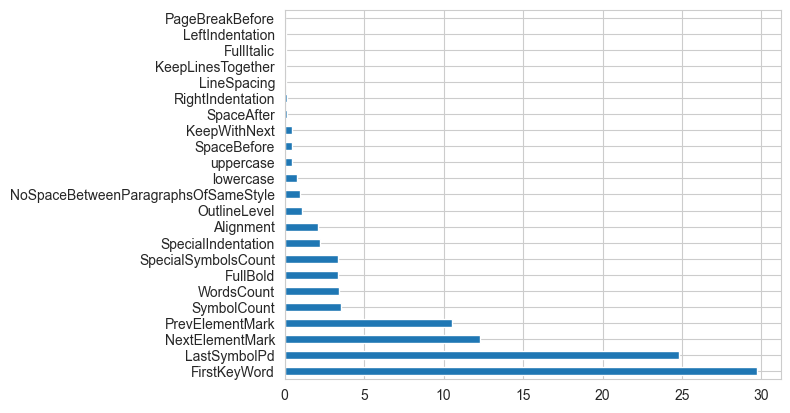

In [83]:
%matplotlib inline  
(pd.Series(res, index=u)
   .nlargest(100)
  .plot(kind='barh')
)

# Графики

## Корреляционные матрицы

In [84]:
df.corr()

,SpecialSymbolsCount,WordsCount,SymbolCount,lowercase,uppercase,LastSymbolPd,FirstKeyWord,PrevElementMark,CurElementMark,NextElementMark,...,KeepWithNext,LeftIndentation,LineSpacing,NoSpaceBetweenParagraphsOfSameStyle,OutlineLevel,PageBreakBefore,RightIndentation,SpaceAfter,SpaceBefore,SpecialIndentation
SpecialSymbolsCount,1.000000,0.906582,0.907100,-0.145407,-0.133061,-0.371884,-0.345776,-0.181191,-0.219361,-0.107794,...,-0.162906,-0.061942,0.102755,-0.050080,-0.171379,-0.061645,0.057020,-0.110689,-0.114628,-0.327847
WordsCount,0.906582,1.000000,0.992021,-0.190765,-0.120597,-0.422143,-0.382138,-0.186211,-0.236434,-0.123402,...,-0.166146,-0.070493,0.121463,-0.086413,-0.179948,-0.057821,0.069151,-0.114676,-0.128637,-0.337216
SymbolCount,0.907100,0.992021,1.000000,-0.195350,-0.122573,-0.435553,-0.404915,-0.212415,-0.255260,-0.140220,...,-0.169138,-0.075767,0.134004,-0.095372,-0.183492,-0.058640,0.070802,-0.119213,-0.125618,-0.349669
lowercase,-0.145407,-0.190765,-0.195350,1.000000,-0.043284,0.507080,0.299022,0.023831,0.130866,0.073784,...,-0.066679,-0.038011,0.050355,0.330021,-0.072873,-0.019625,-0.074441,-0.057597,-0.078475,-0.003082
uppercase,-0.133061,-0.120597,-0.122573,-0.043284,1.000000,0.044050,0.020244,-0.044642,-0.072362,0.019211,...,0.251202,0.024787,-0.055715,-0.041957,0.169509,0.350339,0.020310,0.226992,0.118852,0.112860
LastSymbolPd,-0.371884,-0.422143,-0.435553,0.507080,0.044050,1.000000,0.439124,0.124490,0.314501,0.167379,...,0.058025,0.003301,-0.141992,0.208461,0.066405,0.019973,-0.039032,0.042591,0.035740,0.136343
FirstKeyWord,-0.345776,-0.382138,-0.404915,0.299022,0.020244,0.439124,1.000000,0.451345,0.683529,0.117876,...,0.082849,0.031732,-0.240008,0.074851,0.109561,-0.017141,-0.073530,0.179602,-0.016227,0.383313
PrevElementMark,-0.181191,-0.186211,-0.212415,0.023831,-0.044642,0.124490,0.451345,1.000000,0.537562,0.154628,...,-0.065994,-0.007646,-0.132569,0.054796,-0.048050,-0.044305,-0.063773,0.167075,-0.006538,0.237987
CurElementMark,-0.219361,-0.236434,-0.255260,0.130866,-0.072362,0.314501,0.683529,0.537562,1.000000,0.208084,...,-0.299002,-0.054619,-0.151414,-0.020671,-0.306206,-0.118133,-0.067078,0.225865,-0.189875,0.263814
NextElementMark,-0.107794,-0.123402,-0.140220,0.073784,0.019211,0.167379,0.117876,0.154628,0.208084,1.000000,...,-0.101842,-0.003021,-0.046622,0.111349,-0.099262,-0.038965,-0.002080,0.078335,-0.058595,0.087384


<Axes: >

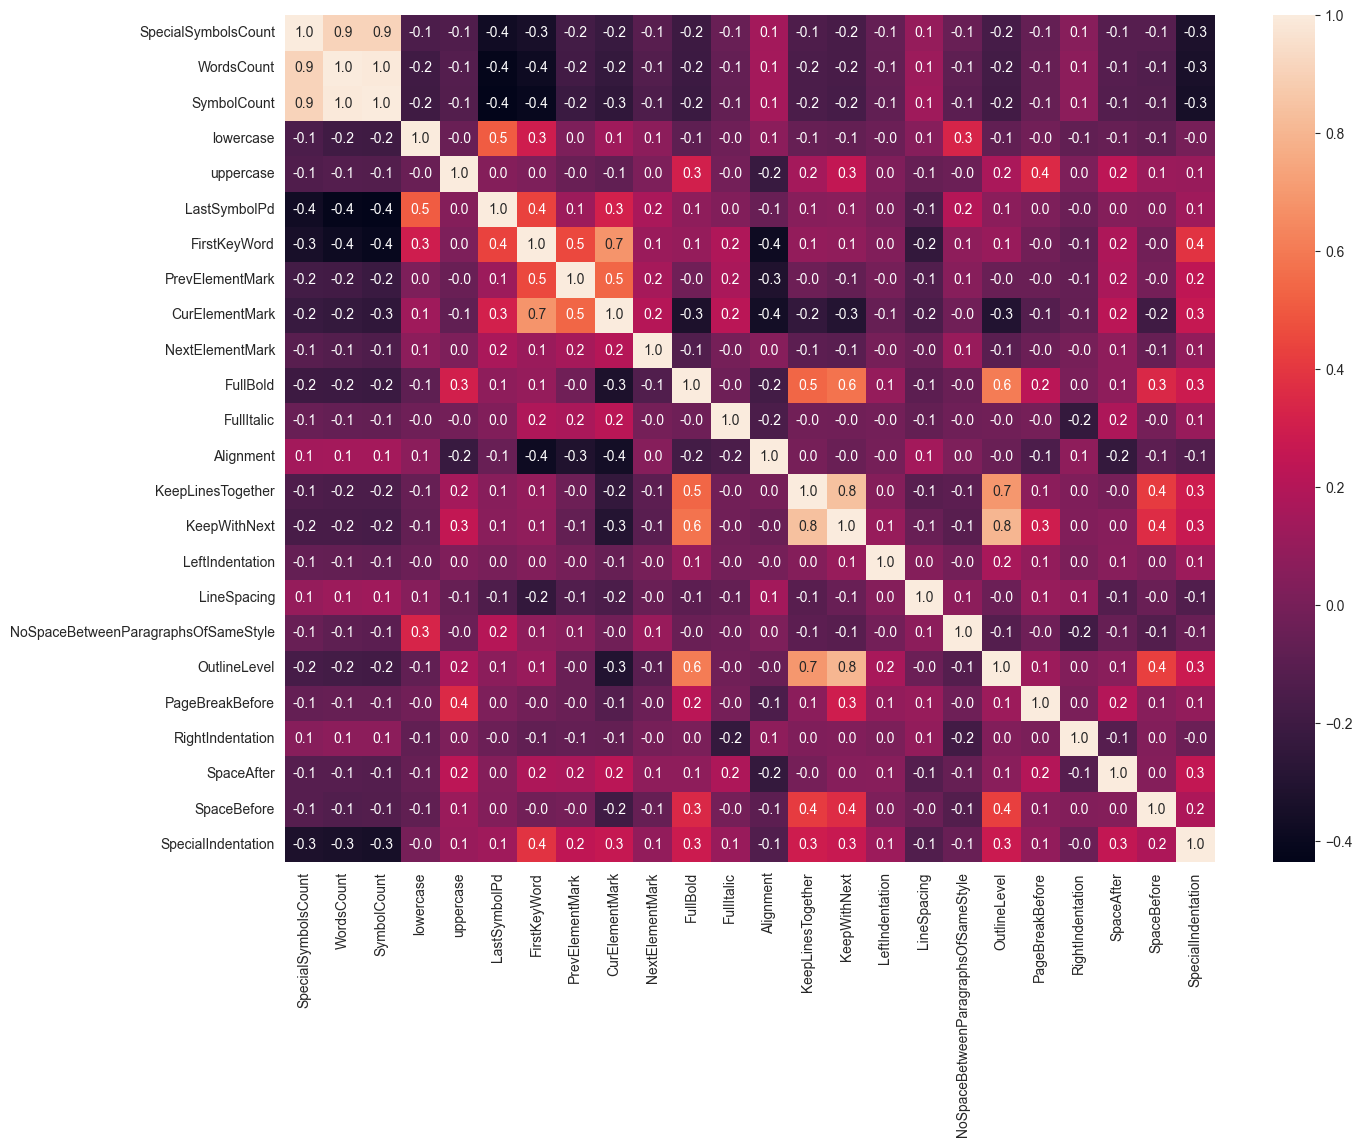

In [85]:
plt.figure(figsize = (15,11))
sns.heatmap(df.corr(), annot = True, fmt = ".1f")